In [2]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Vectorizers 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [3]:
# Load Data
# Insert the combined subreddits and cleaned data - output file from notebook: 02 Data_cleaning and EDA 
combined_cleaned_posts = 'subreddits_extra_features.csv'

posts = pd.read_csv('../data/' + combined_cleaned_posts)

In [4]:
# Preview data
posts.head()

,title,score,id,url,comms_num,created,body,subreddit_science
0,"Before his death, John F. Kennedy's original n...",881,9hp7cr,https://www.reddit.com/r/FakeFacts/comments/9h...,37,1.537561e+09,NaN,0
1,Jumping was created by Thomas Jump when he tri...,761,9va584,https://www.reddit.com/r/FakeFacts/comments/9v...,57,1.541714e+09,NaN,0
2,"until 1939, H2O wasn't water. Water was origin...",731,9uwj3y,https://www.reddit.com/r/FakeFacts/comments/9u...,12,1.541597e+09,NaN,0
3,If you changed the date on your iPhone to one ...,653,9uficc,https://www.reddit.com/r/FakeFacts/comments/9u...,9,1.541468e+09,NaN,0
4,A Female Peacock is Called a Peacunt,640,9vdks8,https://www.reddit.com/r/FakeFacts/comments/9v...,21,1.541737e+09,Edit: Thanks for the Silver!,0


### Baseline Accuracy

In [5]:
posts['subreddit_science'].value_counts(normalize=True)

1    0.502283
0    0.497717
Name: subreddit_science, dtype: float64

### Metrics Function

In [6]:
def metrics(model, X_test, y_test):
    y_predictions = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_predictions).ravel()
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', values_format='d');
    
    accuracy = (tp + tn)/ (tp + tn + fp + fn)
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    precision = tp/(tp + fp)
    
    print(f'***Metrics for {model}***')
    print(f'Accuracy = {accuracy}')
    print(f'Sensitivity = {sensitivity}')
    print(f'Specificity = {specificity}')
    print(f'Precision = {precision}')
    
    return 

### Split Data

In [7]:
# Create a variable to store the target column name. Use this variable name throughtout this notebook to refer to the 
# target for modeling
target = [each for each in posts.columns if each.startswith('subreddit')][0]

In [8]:
# Create a variable to store the feature column name. Use this variable name throughtout this notebook to refer to the 
# feature used for modeling
feature = 'title'

In [9]:
# Set X and y
X = posts[feature]
y = posts[target]

In [10]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Modeling

### Logistic Regression 

Use CountVectorizer to transform the feature column "Title" into words

In [11]:
# Create a pipe object for CountVectorizer and Logistic Regression
logreg_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('logreg', LogisticRegression())
])

In [111]:
# Create a dictionary of the hyperparameters to grid serch in the model
logreg_params = {
    'cvec__max_features': [500, 1000, 1500],
    'cvec__stop_words': [None, 'english'],
    'cvec__min_df': [1, 2, 3], 
    'cvec__max_df': [.9, .95], 
    'logreg__C':[0.5, 1],
    'logreg__penalty': ['l1'],
    'logreg__solver':['liblinear']
}

In [112]:
# Create an instance of GridSearch CV
grid_search_logreg = GridSearchCV(logreg_pipe, logreg_params, cv=5) 

In [113]:
grid_search_logreg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words='english')),
                                       ('logreg', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [500, 1000, 1500],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__stop_words': [None, 'english'],
                         'logreg__C': [0.5, 1], 'logreg__penalty': ['l1'],
                         'logreg__solver': ['liblinear']})

In [114]:
grid_search_logreg.best_score_

0.9093357764544205

In [115]:
grid_search_logreg.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 1000,
 'cvec__min_df': 3,
 'cvec__stop_words': None,
 'logreg__C': 1,
 'logreg__penalty': 'l1',
 'logreg__solver': 'liblinear'}

In [116]:
grid_search_logreg.score(X_train, y_train)

0.979702300405954

In [117]:
grid_search_logreg.score(X_test, y_test)

0.920892494929006

Evaluate this Logistic Regression Model

***Metrics for GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words='english')),
                                       ('logreg', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [500, 1000, 1500],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__stop_words': [None, 'english'],
                         'logreg__C': [0.5, 1], 'logreg__penalty': ['l1'],
                         'logreg__solver': ['liblinear']})***
Accuracy = 0.920892494929006
Sensitivity = 0.8790322580645161
Specificity = 0.963265306122449
Precision = 0.960352422907489


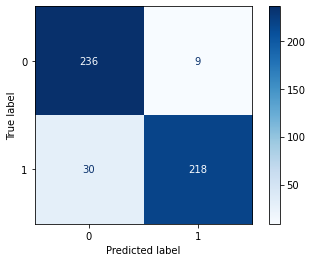

In [118]:
metrics(grid_search_logreg, X_test, y_test)

### Multinomial NB
Hyperparameters in CountVectorizer: stop_words, max_features, max_df, min_df, ngram_range

In [218]:
# Reset X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [219]:
nb_pipe = Pipeline([
    ('cvec', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

In [220]:
nb_params = { 
    'cvec__stop_words': [None, 'english'],
    'cvec__min_df': [1, 2, 3], 
    'cvec__max_df': [.9, .95], 
    'cvec__ngram_range': [(1,1),(2,2)]
}

In [221]:
grid_search_nb = GridSearchCV(nb_pipe, nb_params, cv=5) 

In [222]:
grid_search_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        TfidfVectorizer(stop_words='english')),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95], 'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (2, 2)],
                         'cvec__stop_words': [None, 'english']})

In [223]:
grid_search_nb.best_score_

0.9127393495190106

In [224]:
grid_search_nb.score(X_train, y_train)

0.9749661705006766

In [225]:
grid_search_nb.score(X_test, y_test)

0.9188640973630832

In [226]:
grid_search_nb.best_params_

{'cvec__max_df': 0.9,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

***Metrics for GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        TfidfVectorizer(stop_words='english')),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95], 'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (2, 2)],
                         'cvec__stop_words': [None, 'english']})***
Accuracy = 0.9188640973630832
Sensitivity = 0.9637096774193549
Specificity = 0.8734693877551021
Precision = 0.8851851851851852


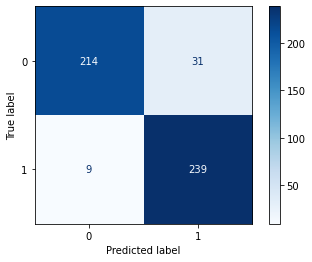

In [227]:
metrics(grid_search_nb, X_test, y_test)

### Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer

In [196]:
# Reset X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [197]:
pipe_tf_vec = Pipeline([
    ('tf_vec', TfidfVectorizer()),
    ('log_reg', LogisticRegression())  
])

In [201]:
tf_vec_params = {
    'tf_vec__max_features':[500, 1000],
    'tf_vec__stop_words': [None,'english'],
    'tf_vec__ngram_range':[(1,1),(1,2)],
    'tf_vec__min_df': [1, 2, 3], 
    'tf_vec__max_df': [.9, .95], 
    #'log_reg__C':[0.2, 0.5, 1],
    'log_reg__penalty': ['l1'],
    'log_reg__solver':['liblinear']
}


In [202]:
gs_tf_vec = GridSearchCV(pipe_tf_vec, tf_vec_params, cv=5, verbose=1)

In [203]:
gs_tf_vec.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   17.4s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf_vec', TfidfVectorizer()),
                                       ('log_reg', LogisticRegression())]),
             param_grid={'log_reg__penalty': ['l1'],
                         'log_reg__solver': ['liblinear'],
                         'tf_vec__max_df': [0.9, 0.95],
                         'tf_vec__max_features': [500, 1000],
                         'tf_vec__min_df': [1, 2, 3],
                         'tf_vec__ngram_range': [(1, 1), (1, 2)],
                         'tf_vec__stop_words': [None, 'english']},
             verbose=1)

In [204]:
gs_tf_vec.best_score_

0.8775355016032982

In [205]:
gs_tf_vec.best_params_

{'log_reg__penalty': 'l1',
 'log_reg__solver': 'liblinear',
 'tf_vec__max_df': 0.9,
 'tf_vec__max_features': 500,
 'tf_vec__min_df': 2,
 'tf_vec__ngram_range': (1, 1),
 'tf_vec__stop_words': None}

In [206]:
gs_tf_vec.score(X_train, y_train), gs_tf_vec.score(X_test, y_test)

(0.9181326116373477, 0.9026369168356998)

***Metrics for GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf_vec', TfidfVectorizer()),
                                       ('log_reg', LogisticRegression())]),
             param_grid={'log_reg__penalty': ['l1'],
                         'log_reg__solver': ['liblinear'],
                         'tf_vec__max_df': [0.9, 0.95],
                         'tf_vec__max_features': [500, 1000],
                         'tf_vec__min_df': [1, 2, 3],
                         'tf_vec__ngram_range': [(1, 1), (1, 2)],
                         'tf_vec__stop_words': [None, 'english']},
             verbose=1)***
Accuracy = 0.9026369168356998
Sensitivity = 0.8709677419354839
Specificity = 0.9346938775510204
Precision = 0.9310344827586207


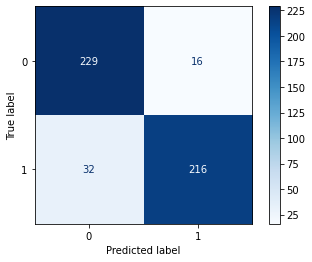

In [207]:
metrics(gs_tf_vec, X_test, y_test)

### Random Forest

In [228]:
# Reset X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [229]:
rf_pipe = Pipeline([
    ('tf_vec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

In [233]:
rf_params = {
    'tf_vec__max_features': [1000, 3000],
    'tf_vec__stop_words': [None, 'english'],
    'tf_vec__ngram_range': [(1,1),(1,2)],
    'tf_vec__use_idf' : [ True, False],
    'rf__n_estimators': [80, 90, 100],
    'rf__max_depth': [None, 2],
    'rf__max_features': ['auto', None]
}

In [234]:
rf_gs = GridSearchCV(rf_pipe, rf_params, cv=5)

In [235]:
rf_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf_vec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [None, 2],
                         'rf__max_features': ['auto', None],
                         'rf__n_estimators': [80, 90, 100],
                         'tf_vec__max_features': [1000, 3000],
                         'tf_vec__ngram_range': [(1, 1), (1, 2)],
                         'tf_vec__stop_words': [None, 'english'],
                         'tf_vec__use_idf': [True, False]})

In [236]:
rf_gs.score(X_train, y_train), rf_gs.score(X_test, y_test)

(1.0, 0.922920892494929)

In [237]:
rf_gs.best_score_

0.9039418231791114

In [238]:
rf_gs.best_params_

{'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__n_estimators': 90,
 'tf_vec__max_features': 1000,
 'tf_vec__ngram_range': (1, 2),
 'tf_vec__stop_words': None,
 'tf_vec__use_idf': False}

In [239]:
rf_gs.best_estimator_

Pipeline(steps=[('tf_vec',
                 TfidfVectorizer(max_features=1000, ngram_range=(1, 2),
                                 use_idf=False)),
                ('rf', RandomForestClassifier(n_estimators=90))])

***Metrics for GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf_vec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [None, 2],
                         'rf__max_features': ['auto', None],
                         'rf__n_estimators': [80, 90, 100],
                         'tf_vec__max_features': [1000, 3000],
                         'tf_vec__ngram_range': [(1, 1), (1, 2)],
                         'tf_vec__stop_words': [None, 'english'],
                         'tf_vec__use_idf': [True, False]})***
Accuracy = 0.922920892494929
Sensitivity = 0.8830645161290323
Specificity = 0.963265306122449
Precision = 0.9605263157894737


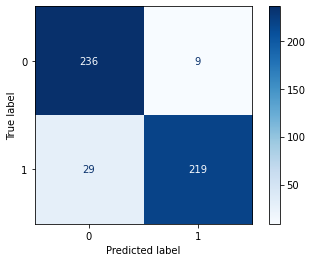

In [240]:
metrics(rf_gs, X_test, y_test)